In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns
# sns.set_style('whitegrid')

import covid19

## data

In [3]:
date_italy_regions_path = 'dpc-covid19-ita-regioni.csv'
# date_italy_regions_path = covid19.data.download('regioni')


In [4]:
data_italy_regions = pd.read_csv(date_italy_regions_path, parse_dates=['data'], index_col=['data'])
data_italy_regions['totale_terapia_intensiva'] = data_italy_regions['terapia_intensiva'] + data_italy_regions['deceduti']
data_italy_regions['totale_ricoverati'] = data_italy_regions['ricoverati_con_sintomi'] + data_italy_regions['totale_terapia_intensiva']

data_italy_regions.index = data_italy_regions.index.normalize()

print(sorted(data_italy_regions['denominazione_regione'].unique().tolist()))

data_italy_regions.loc[data_italy_regions.index.max()].sort_values('ricoverati_con_sintomi', ascending=False)[['denominazione_regione', 'ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti']]


['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche', 'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta", 'Veneto']


,denominazione_regione,ricoverati_con_sintomi,terapia_intensiva,deceduti
data,,,,
2020-03-20,Lombardia,7735,1050,2549
2020-03-20,Emilia Romagna,2083,267,640
2020-03-20,Piemonte,1541,280,209
2020-03-20,Veneto,843,236,131
2020-03-20,Marche,704,138,137
2020-03-20,Toscana,601,189,47
2020-03-20,Liguria,573,121,119
2020-03-20,Lazio,537,47,43
2020-03-20,P.A. Trento,198,34,13


## situation report

In [5]:
DAY = np.timedelta64(24 * 60 * 60,'s')

START_FIT = None
CHANGE_FIT_1 = np.datetime64('2020-03-05')
CHANGE_FIT_2 = np.datetime64('2020-03-11')
CHANGE_FIT_3 = np.datetime64('2020-03-15')
STOP_FIT = None

EXTRAPOLTATE = ('2020-02-23', '2020-03-22')

REGIONS_FIT_PARAMS = {
    'Lombardia': {
        'exponential_fits': [(None, '2020-03-06'), ('2020-03-09', '2020-03-12'), ('2020-03-13', '2020-03-17'), ('2020-03-18', None)],
        # 'exponential_fits': [(None, '2020-03-11'), ('2020-03-12', None)],
    },
    'Emilia Romagna': {
        'exponential_fits': [(None, '2020-03-01'), ('2020-03-02', '2020-03-06'), ('2020-03-07', None)]
    },
    'Piemonte': {
        'exponential_fits': [(None, '2020-03-10'), ('2020-03-11', None)]
    },
    'Veneto': {
        'exponential_fits': [(None, '2020-03-12'), ('2020-03-13', None)],
    },
    'Marche': {
        'exponential_fits': [(None, '2020-03-06'), ('2020-03-07', '2020-03-15'), ('2020-03-16', None)]
    },
    'Toscana': {
        'exponential_fits': [(None, '2020-03-08'), ('2020-03-10', '2020-03-16'), ('2020-03-17', None)]
    },
    'Liguria': {
        'exponential_fits': [('2020-03-04', '2020-03-15'), ('2020-03-16', None)]
    },
    'Lazio':  {
        'exponential_fits': [(None, '2020-03-13'), ('2020-03-14', None)]
    },
    'P.A. Trento': {},
    'Puglia': {
        'exponential_fits': [(None, '2020-03-15'), ('2020-03-16', None)]
    },
    'Abbruzzo': {},
    'Sicilia': {
        'exponential_fits': [('2020-03-08', None)]
    },
    'Friuli Venezia Giulia': {
        'exponential_fits': [(None, '2020-03-15'), ('2020-03-16', None)]
    },
    'Campania': {
        'exponential_fits': [(None, None)]
    },
    'P.A. Bolzano': {},
    'Basilicata': {},
    'Calabria': {
        'exponential_fits': [('2020-03-08', None)]
    },
    'Molise': {},
    'Sardegna': {},

    'Umbria': {
        'exponential_fits': [(None, None)]
    },
    "Valle d'Aosta": {},
}
    
DELAY = 12 * DAY
PALETTE_ONE = list(sns.color_palette())
PALETTE = itertools.cycle(PALETTE_ONE)

In [6]:
fits = {}
for region, params in REGIONS_FIT_PARAMS.items():
    for kind in ['ricoverati_con_sintomi', 'deceduti']:
        exponential_fits = params.get('exponential_fits', [(START_FIT, CHANGE_FIT_1), (CHANGE_FIT_1 + DAY, CHANGE_FIT_2), (CHANGE_FIT_2 + DAY, CHANGE_FIT_3), (CHANGE_FIT_3 + DAY, STOP_FIT)])
        fits[region, kind] = []
        for start, stop in exponential_fits:
            try:
                select = (data_italy_regions['denominazione_regione'] == region) & (data_italy_regions[kind] >= 8)
                fits[region, kind] += [covid19.fit.ExponentialFit.from_frame(kind, data_italy_regions[select], start=start, stop=stop)]
            except:
                print('skipping:', region, start, stop)

skipping: Marche None 2020-03-06
skipping: Toscana None 2020-03-08
skipping: P.A. Trento None 2020-03-05
skipping: P.A. Trento None 2020-03-05
skipping: P.A. Trento 2020-03-06T00:00:00 2020-03-11
skipping: P.A. Trento 2020-03-12T00:00:00 2020-03-15
skipping: Abbruzzo None 2020-03-05
skipping: Abbruzzo 2020-03-06T00:00:00 2020-03-11
skipping: Abbruzzo 2020-03-12T00:00:00 2020-03-15
skipping: Abbruzzo 2020-03-16T00:00:00 None
skipping: Abbruzzo None 2020-03-05
skipping: Abbruzzo 2020-03-06T00:00:00 2020-03-11
skipping: Abbruzzo 2020-03-12T00:00:00 2020-03-15
skipping: Abbruzzo 2020-03-16T00:00:00 None
skipping: Sicilia 2020-03-08 None
skipping: P.A. Bolzano None 2020-03-05
skipping: P.A. Bolzano None 2020-03-05
skipping: P.A. Bolzano 2020-03-06T00:00:00 2020-03-11
skipping: P.A. Bolzano 2020-03-12T00:00:00 2020-03-15
skipping: Basilicata None 2020-03-05
skipping: Basilicata 2020-03-06T00:00:00 2020-03-11
skipping: Basilicata 2020-03-12T00:00:00 2020-03-15
skipping: Basilicata None 2020-0

No data for Abbruzzo


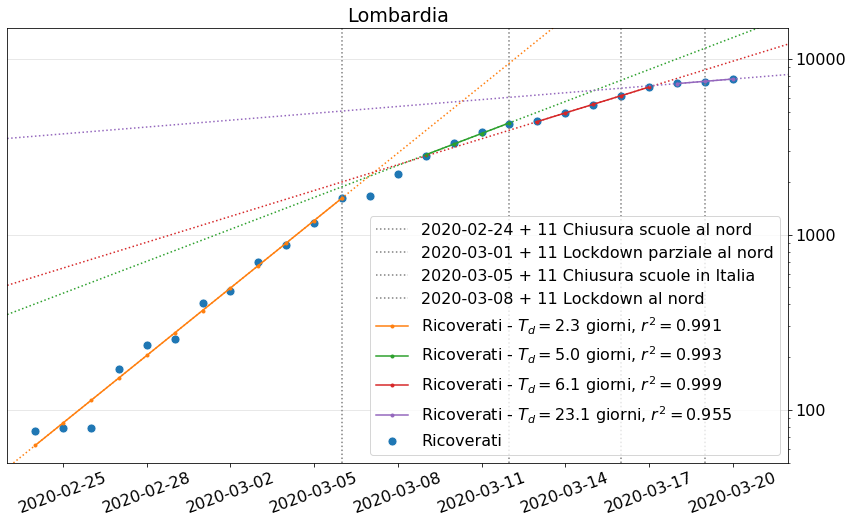

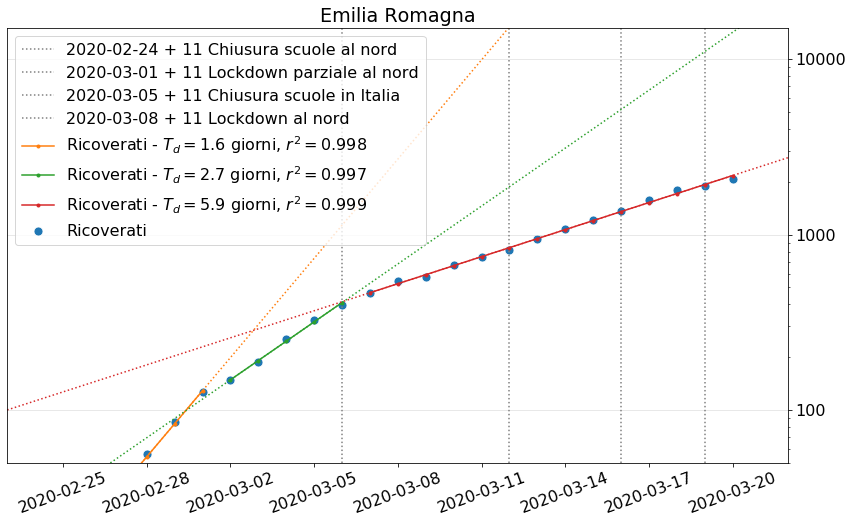

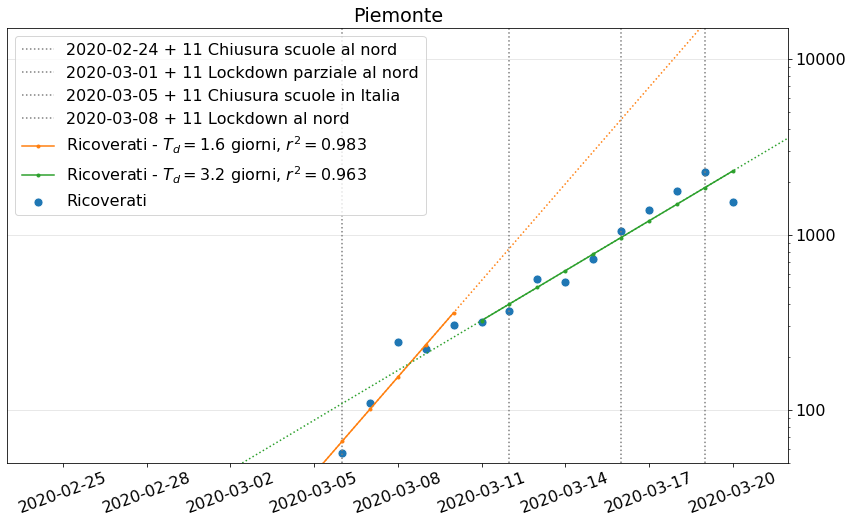

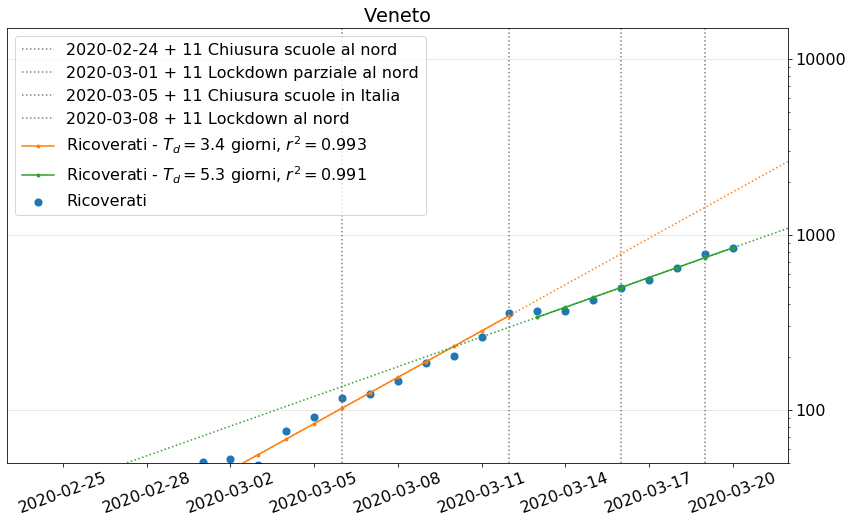

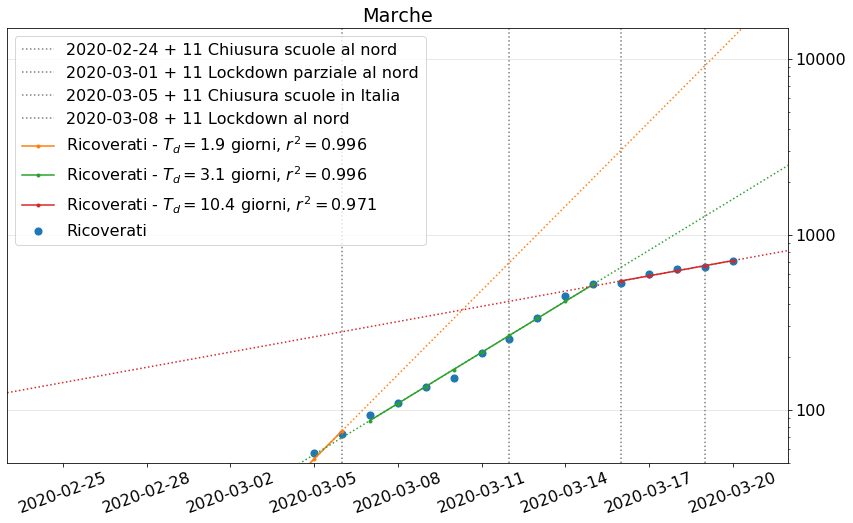

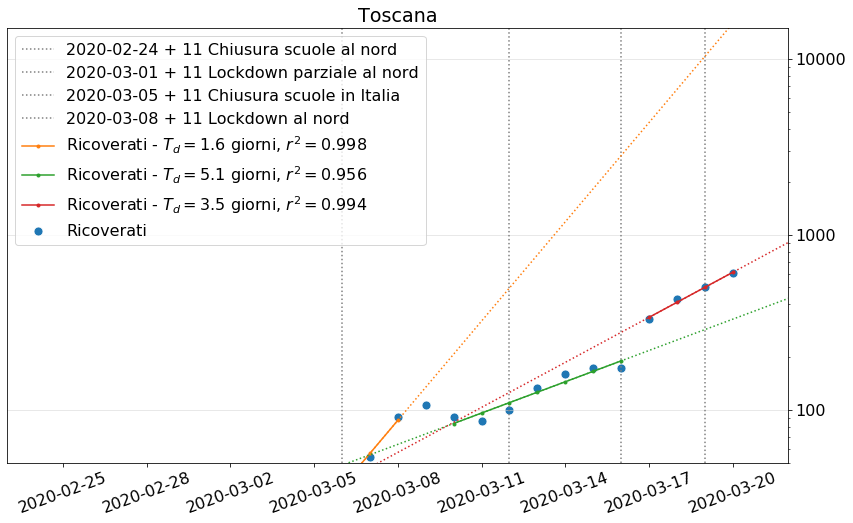

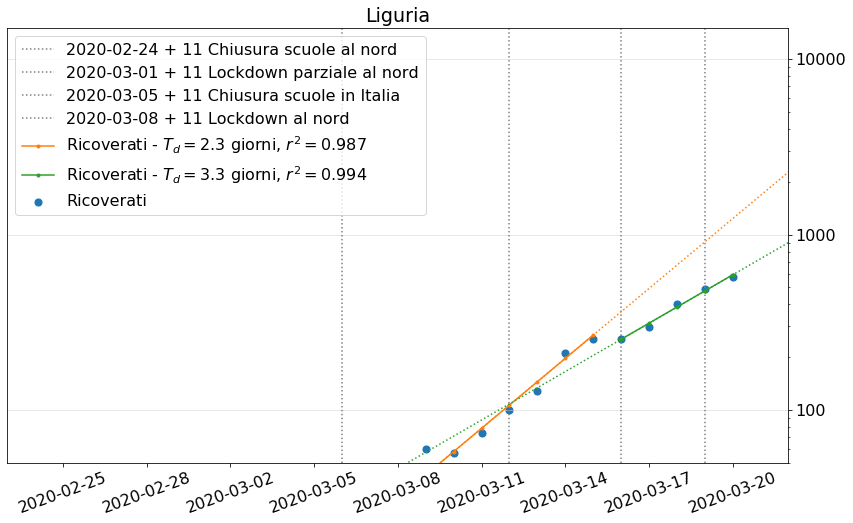

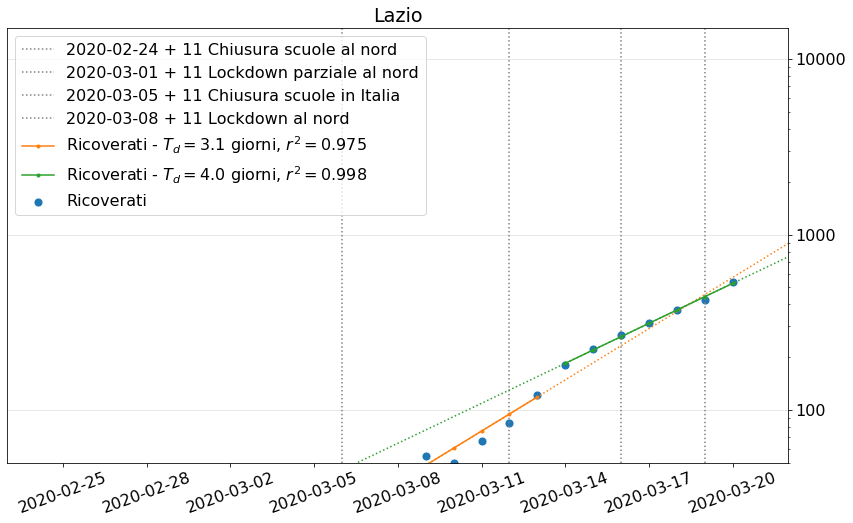

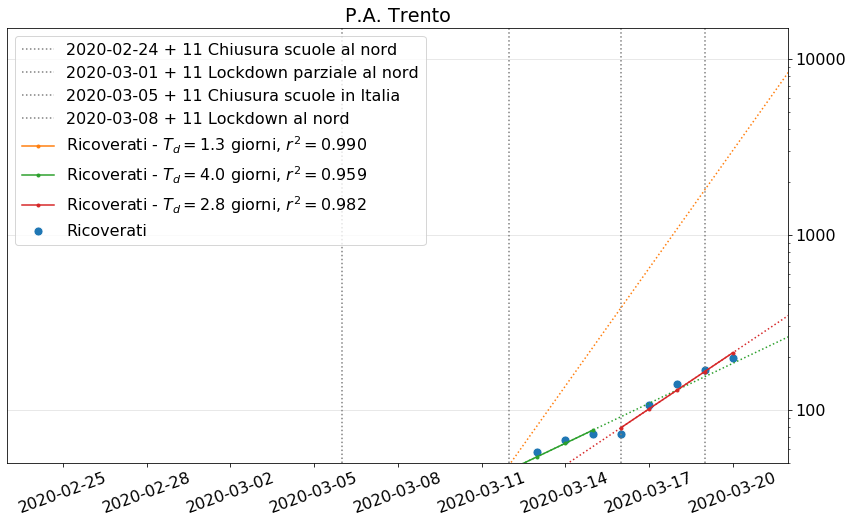

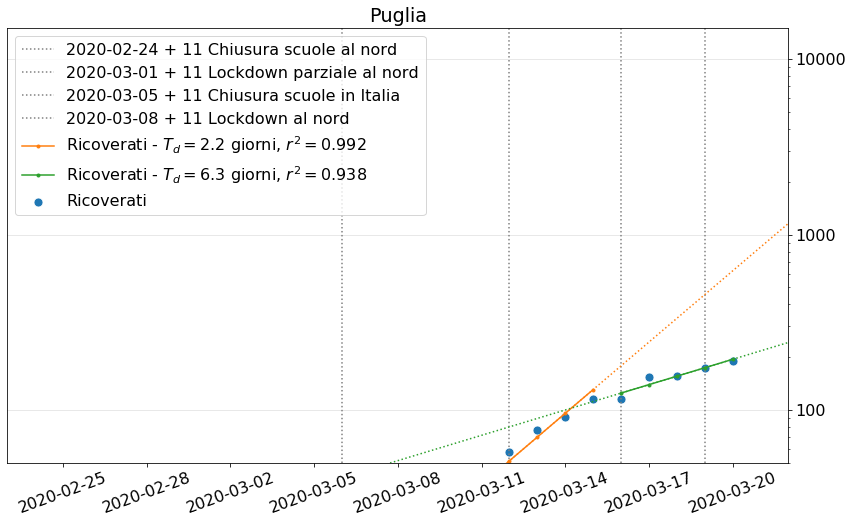

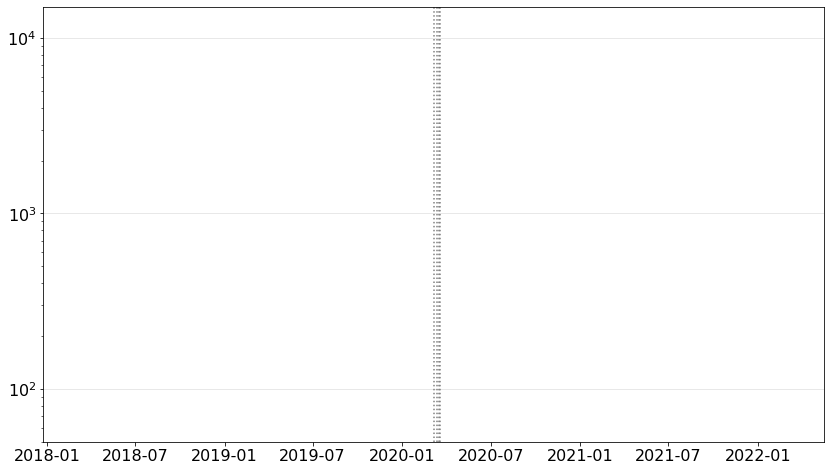

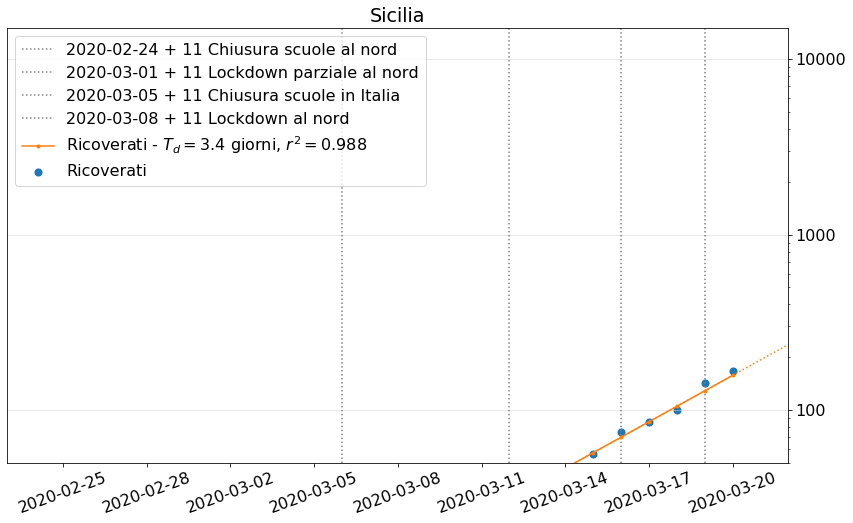

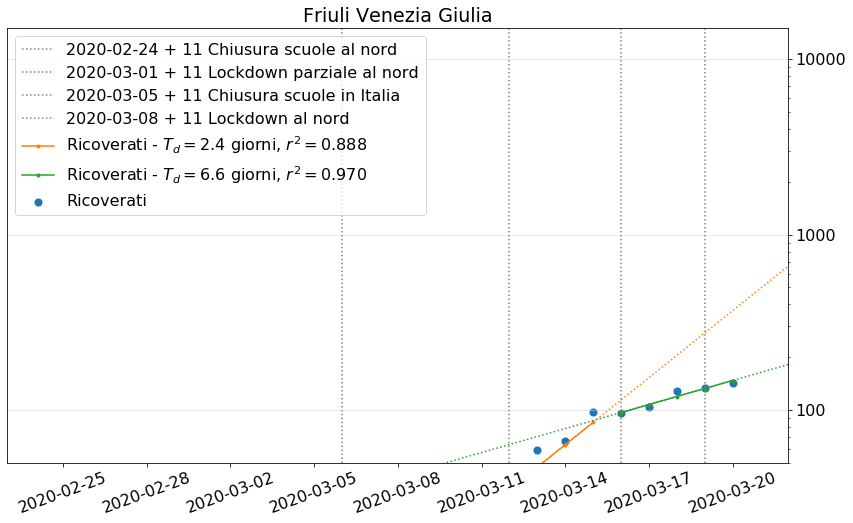

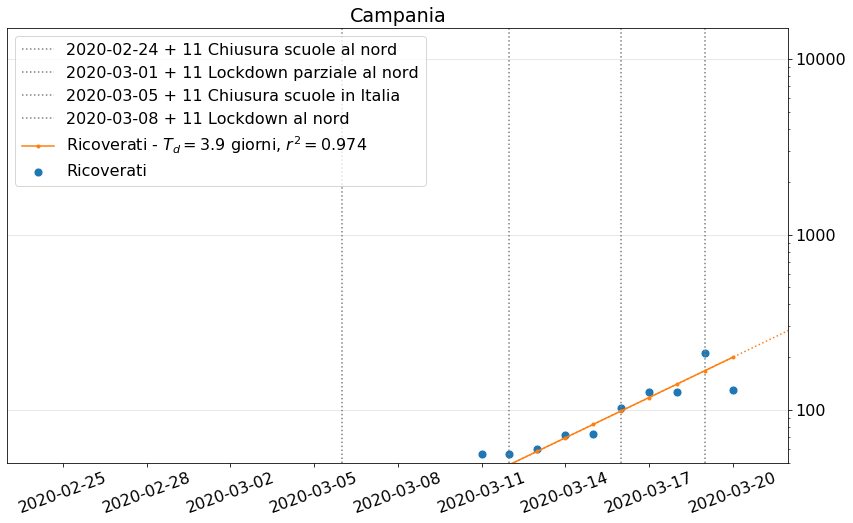

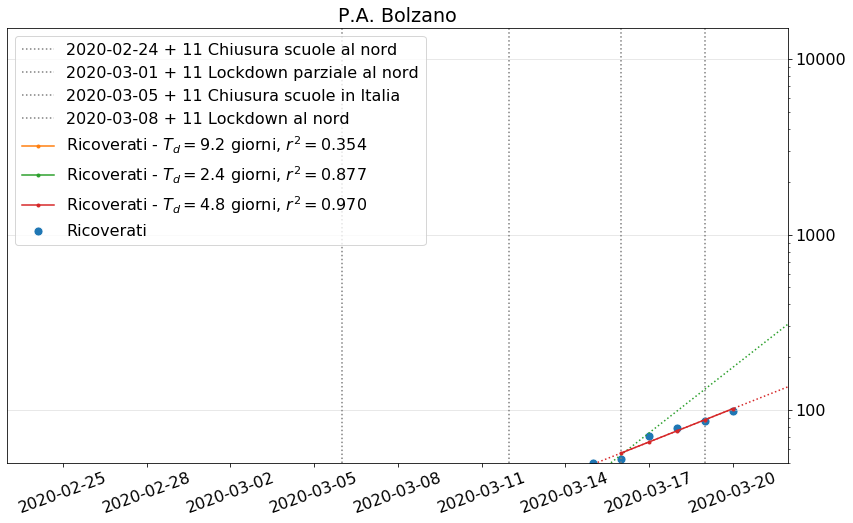

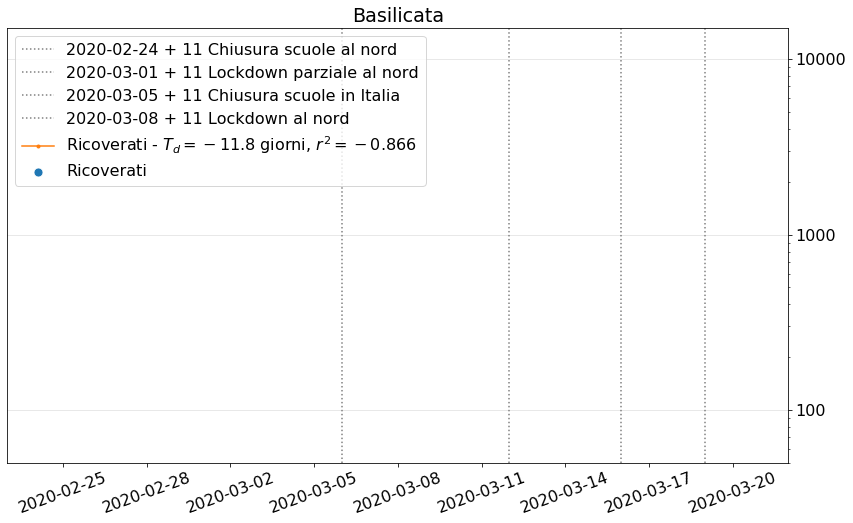

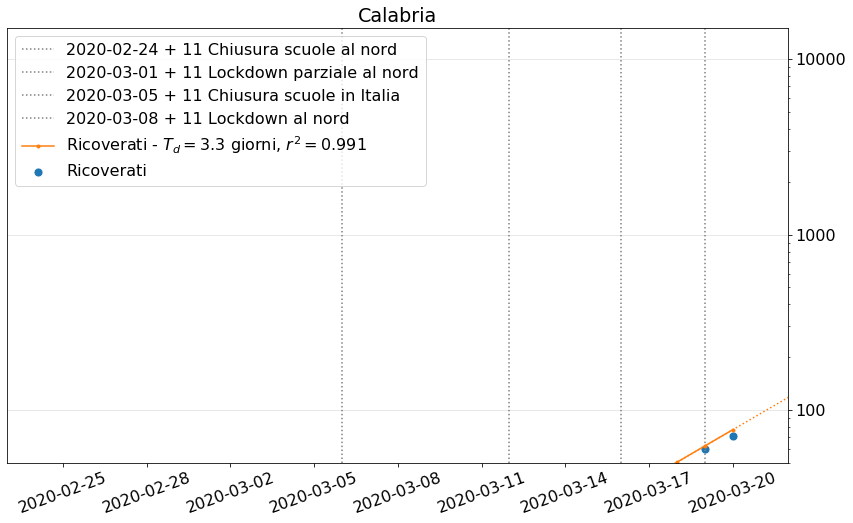

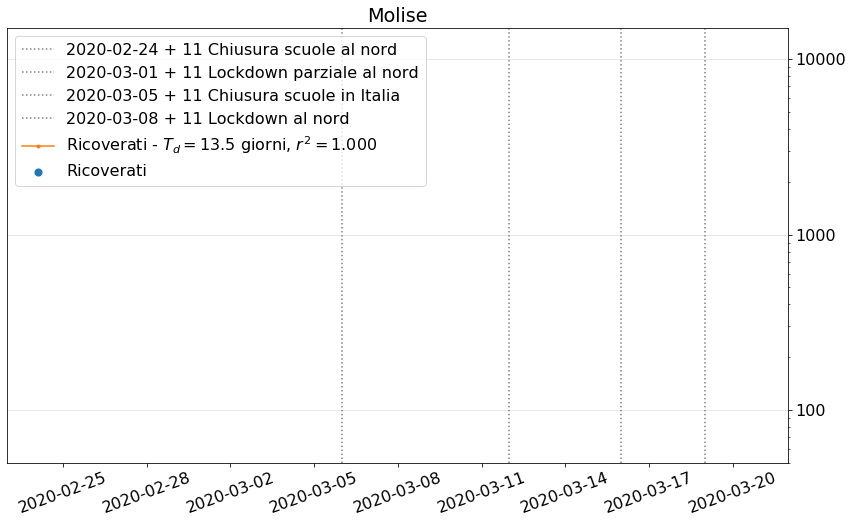

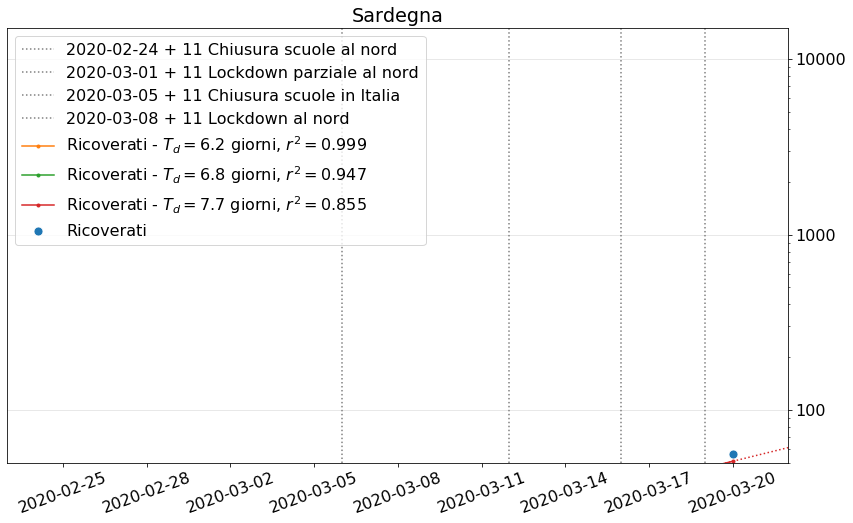

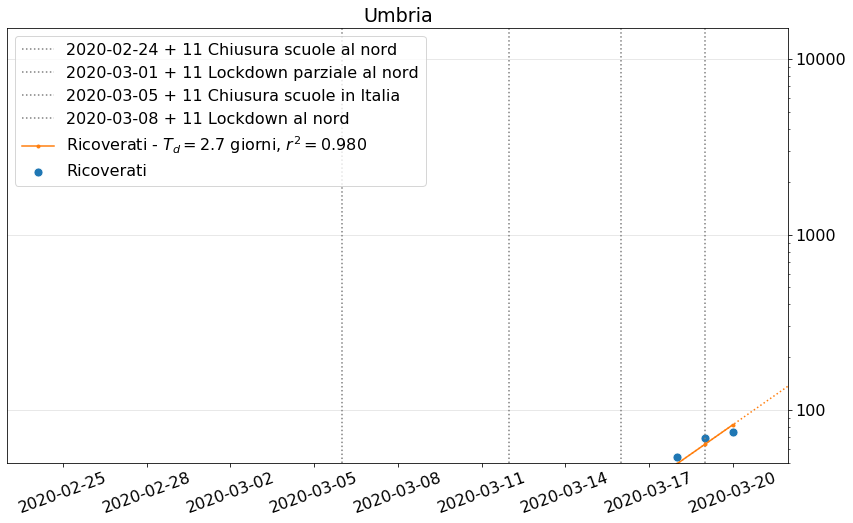

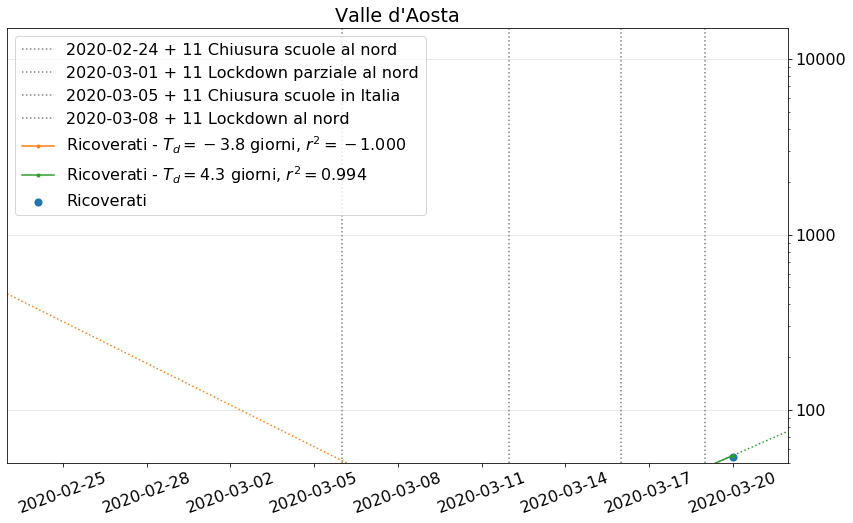

In [7]:
for region in REGIONS_FIT_PARAMS:
    select = (data_italy_regions['denominazione_regione'] == region)
    for kind in ['ricoverati_con_sintomi']:
        _, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (50, 15000)}, figsize=(14, 8))
        _ = ax.yaxis.grid(color='lightgrey', linewidth=0.5)
        _ = covid19.plot.add_events(ax, linestyle=':', offset=11, color='grey')
        if len(fits[region, kind]) == 0:
            print('No data for', region)
            continue
        try:
            for fit, color in zip(fits[region, kind], PALETTE_ONE[1:]):
                covid19.plot.plot_fit(ax, fit, label=kind.split('_')[0].title(), extrapolate=EXTRAPOLTATE, color=color)
            covid19.plot.plot_data(ax, data_italy_regions[select][kind], label=kind.split('_')[0].title(), color=PALETTE_ONE[0], date_interval=3)
            ax.set_title(f'{region}')
            _ = ax.yaxis.grid(color='lightgrey', linewidth=0.5)
            _ = ax.yaxis.tick_right()
        except:
            pass

#_ = ax.set(title=r'COVID-19 "severe" cases in Italy. Fit is $f(t) = 2 ^ \frac{t - t_0}{T_d}$, with $T_d$ doubling time and $t_0$ reference date')


## Estimate of the initial / uncontined doubling time

In [8]:
for key, value in list(fits.items()):
    if len(value):
        print(f'{key[0]}:{" " * (14 - len(key[0]))} {str(value[0])}')

Lombardia:      T_d=2.35, t_0='2020-02-09', r^2=0.991 start='2020-02-24', stop='2020-03-06'
Lombardia:      T_d=2.47, t_0='2020-02-17', r^2=0.993 start='2020-02-25', stop='2020-03-06'
Emilia Romagna: T_d=1.60, t_0='2020-02-18', r^2=0.998 start='2020-02-24', stop='2020-03-01'
Emilia Romagna: T_d=nan, t_0='NaT', r^2=0.000 start='2020-03-01', stop='2020-03-01'
Piemonte:       T_d=1.64, t_0='2020-02-25', r^2=0.983 start='2020-03-01', stop='2020-03-10'
Piemonte:       T_d=2.58, t_0='2020-02-28', r^2=1.000 start='2020-03-09', stop='2020-03-10'
Veneto:         T_d=3.42, t_0='2020-02-12', r^2=0.993 start='2020-02-24', stop='2020-03-12'
Veneto:         T_d=3.95, t_0='2020-02-20', r^2=0.992 start='2020-03-05', stop='2020-03-12'
Marche:         T_d=1.88, t_0='2020-02-23', r^2=0.996 start='2020-03-01', stop='2020-03-06'
Marche:         T_d=2.76, t_0='2020-02-28', r^2=0.998 start='2020-03-09', stop='2020-03-15'
Toscana:        T_d=1.60, t_0='2020-02-26', r^2=0.998 start='2020-03-03', stop='2020-03-

In [9]:
for key, value in list(fits.items()):
    if len(value):
        print(f'{key[0]}:{" " * (14 - len(key[0]))} {str(value[-1])}')

Lombardia:      T_d=23.13, t_0='2019-05-26', r^2=0.955 start='2020-03-18', stop='2020-03-20'
Lombardia:      T_d=5.27, t_0='2020-01-20', r^2=0.991 start='2020-03-18', stop='2020-03-20'
Emilia Romagna: T_d=5.86, t_0='2020-01-15', r^2=0.999 start='2020-03-07', stop='2020-03-20'
Emilia Romagna: T_d=3.36, t_0='2020-02-17', r^2=0.994 start='2020-03-07', stop='2020-03-20'
Piemonte:       T_d=3.18, t_0='2020-02-13', r^2=0.963 start='2020-03-11', stop='2020-03-20'
Piemonte:       T_d=2.67, t_0='2020-02-27', r^2=0.980 start='2020-03-11', stop='2020-03-20'
Veneto:         T_d=5.34, t_0='2020-01-28', r^2=0.991 start='2020-03-13', stop='2020-03-20'
Veneto:         T_d=4.48, t_0='2020-02-17', r^2=0.995 start='2020-03-13', stop='2020-03-20'
Marche:         T_d=10.40, t_0='2019-12-12', r^2=0.971 start='2020-03-16', stop='2020-03-20'
Marche:         T_d=3.06, t_0='2020-02-27', r^2=0.997 start='2020-03-16', stop='2020-03-20'
Toscana:        T_d=3.52, t_0='2020-02-16', r^2=0.994 start='2020-03-17', stop